# IE 411 - Final Project 


<br>

**Submitted by:** Jayesh Yevale <br>
**NetID:** jyeval2<br>

## Introduction

We consider a Image for the seam carving problem. In this project, our primary objective is to tackle a large-scale linear problem using a standard programming language, which is Python in this project, in conjuction with widely known optimization tool known as Gurobi. The image seam carving problem can be formulated as a max-flow problem.

In this project, we plan to utilize our knowledge of IE 411 - Optimization of Large Systems, background to implement the tool for image resizing. We will use max-flow technique to resize the image iteratively for identitfying the nodes to be eliminated. Every iteration we will identify and eliminate the nodes for next iteration. This will help us to find the final "resized" image as expected.

## Problem Formulation

For the problem formulation, we decided to use the given information such as the cost is the sum of absolute intensity differences, and the node traversal assumption given in the project problem documentation.

We will consider the image to be a set of nodes, where each pixel denotes an independent node. Let us  us consider the graph $\mathcal{G} = (\mathcal{N},\mathcal{E})$, where $\mathcal{N}$ are nodes and $\mathcal{E}$ are edges. The graph is created with nodes $(i,j) \in \mathcal{I} \times \mathcal{J}$, where $\mathcal{I} = \{1,\ldots,m\}$ and $\mathcal{J} = \{1,\ldots,n\}$. The nodes corresponds to pixels in the input image. Node $(k,l) \in \mathcal{I} \times \mathcal{J}$ can be traversed from node $(i,j) \in \mathcal{I} \times \mathcal{J}$ if:<br>
(a) $k = i+1$, and <br>
(b) $l$ is either $j-1, j$ or $j+1$.<br>

The graph also has a dummy terminal node $t$ that can be traversed from any nodes $(m,j)$, $j = 1,\ldots,n.$

The cost of traversing from node $(i,j)$ to node $(k,l)$ is given by $|y(i,j)-y(k,l)|$, where $y$ is intensity of pixels.

Let us now formulate a linear program to compute the shortest path from source node $(1,j)$ (where $j = 50$ in our given problem) to the terminal node $t$. The optimal path of the linear program would correspond to a seam. We will repeat the steps for 25 iteration to find the final image.

### Primal Formulation

**Decision variable:**

$f$ : represents the actual flow on a edge.

**Parameters**

$\mathbf{A}$: Incidence matrix, which captures the node-node relationship $\in \mathbb{R}^{m\times n}$.

$b=\begin{cases}
-1, \qquad&\text{for source node } s\\
1, &\text{for terminal node } t\\
0, &\text{else}
\end{cases}$

$c$: Capacity of an edge (denoted as "Cap" in coding)


\begin{equation*}
\begin{aligned}
\min&\quad cf\\
\text{s.t.} & \\
& \mathbf{A}f = b\\
& f\ge 0
\end{aligned}
\end{equation*}

### Dual formulation:

**Decision variable:**

$z$ : represents the new dual decision variable.

\begin{equation*}
\begin{aligned}
\max&\quad zb\\
\text{subject to:} & \\
& \mathbf{A}^\top z \le c\\
&z \text{ free}
\end{aligned}
\end{equation*}

### Complementary slackness:

For complementary slackness, we considered the matrix version as shown in class (for image segmentation).

\begin{align*}
z\left(\mathbf{A}f-b\right) =0\\
f\left(c - \mathbf{A}^\top z\right) = 0
\end{align*}

This holds true for our cases. Hence, verified.

In [ ]:
from PIL import Image
import gurobipy as gp
from gurobipy import GRB
from gurobipy import *
import gurobipy as gp
import numpy as np
import networkx as nx
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
im = Image.open('tower.png').convert('L') #convert to grayscale
h = im.height
w = im.width

tic = time.time()

#grayscale values; list of size h*w , where each values is integer in range [0,255]
intensity = list(im.getdata()) 

def get_weight(n1,n2):
    if n2 == t:
        diff = 0
    else:
        diff = intensity[n1-1] - intensity[n2-1]
    return np.abs(diff)

#define indexes
def idx(i,j):
    return w*(i-1)+j

#specify source node
s = 50

In [11]:
for q in range(25):

    #list of coordinates
    coords = [(i,j) for i in range(1,h+1) for j in range(1,w+1)]

    nodes = [idx(i,j) for i,j in coords]

    #add destination (t) to nodes
    t = h*w+1
    nodes.append(t)

    #define neighbors
    ngbrs = {idx(i,j): [idx(i2,j2) for (i2,j2) in [(i+1,j-1),(i+1,j),(i+1,j+1)] 
                          if 1<= i2 <= h and 1<= j2 <= w] for (i,j) in coords}

    #add neighbors for destination nodes
    for (i,j) in coords:
        if i ==h:
            ngbrs[idx(i,j)].append(t) 

    #define edges
    edges = [(n1,n2) for n1 in nodes[:-1] for n2 in ngbrs[n1]]
    
    #define incident matrix
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    A = nx.incidence_matrix(G, oriented= True)
    
    #intialization
    cap = np.zeros(G.number_of_edges())
    r = np.zeros(G.number_of_edges())
    for i in range(G.number_of_edges()):
        r[i] = get_weight(edges[i][0],edges[i][1])
    
    #define the primal problem
    m = gp.Model("Primal Image Seaming")
    m.setParam('OutputFlag', 0)
    m.Params.LogToConsole = 0
    m.Params.Method = 0
    f = m.addMVar(G.number_of_edges(), vtype=GRB.CONTINUOUS,lb=0)
    b = np.zeros(G.number_of_nodes())
    b[s-1] = -1
    b[-1] = 1
    m.addConstr(A@f==b)    
    obj= r@f
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    print("\nIteration: ",q+1,"\nPrimal Objective: ",m.getObjective().getValue())
    
    if q == 0:
        toc = time.time()
    
    #remove the seam nodes
    flows = m.getAttr("X", m.getVars())
    to_remove = [] # get the indices of nodes (pixels) to be removed
    for i in range(G.number_of_edges()):
        if flows[i] >= 0.9:
            to_remove.append(edges[i][0]-1) #0 indexed
    intensity = [I for idx,I in enumerate(intensity) if idx not in to_remove]
    w = w - 1
    
    #DUAL PROBLEM
    mm = gp.Model("Dual Image Seaming")
    mm.Params.LogToConsole = 0
    mm.Params.Method = 0
    z = mm.addMVar(shape=G.number_of_nodes(), vtype=GRB.CONTINUOUS, name="z")
    obj = b@z

    mm.addConstr(r>=A.transpose()@z)
    mm.setObjective(obj, GRB.MAXIMIZE)
    mm.optimize()
    print("Dual objective:   ", mm.getObjective().getValue())
    dual_vars = mm.getAttr("X", mm.getVars())

    #Check complementary slackness conditions
    cuts = dual_vars[:G.number_of_edges()]
    y = dual_vars[G.number_of_edges():]
    cmaxflows = A@flows - b
    print('Complementary slackness: ', cmaxflows@cuts)
    Aty_plus_z_min_r = r - A.transpose()@dual_vars
    print('Complementary slackness: ', Aty_plus_z_min_r@flows)


Iteration:  1 
Primal Objective:  395.0
Dual objective:    395.0
Complementary slackness:  0.0
Complementary slackness:  0.0

Iteration:  2 
Primal Objective:  402.0
Dual objective:    402.0
Complementary slackness:  0.0
Complementary slackness:  0.0

Iteration:  3 
Primal Objective:  410.0
Dual objective:    410.0
Complementary slackness:  0.0
Complementary slackness:  0.0

Iteration:  4 
Primal Objective:  419.0
Dual objective:    419.0
Complementary slackness:  0.0
Complementary slackness:  0.0

Iteration:  5 
Primal Objective:  432.0
Dual objective:    432.0
Complementary slackness:  0.0
Complementary slackness:  0.0

Iteration:  6 
Primal Objective:  436.0
Dual objective:    436.0
Complementary slackness:  0.0
Complementary slackness:  0.0

Iteration:  7 
Primal Objective:  444.0
Dual objective:    444.0
Complementary slackness:  0.0
Complementary slackness:  0.0

Iteration:  8 
Primal Objective:  450.0
Dual objective:    450.0
Complementary slackness:  0.0
Complementary slacknes

In [12]:
# resize final intensities and save as an image
arr = np.reshape(intensity,(h,w)).astype('uint8')
final_image = Image.fromarray(arr)
final_image.save('final_image.png')

print ('elapsed ', toc - tic)

elapsed  18.224509477615356


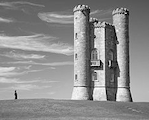

In [13]:
final_image